In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog  # Added hog explicitly

In [2]:
class MorphDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        bona_fide_dir = os.path.join(root_dir, 'Bona fide')
        morph_dir = os.path.join(root_dir, 'Morph')

        for label, class_dir in enumerate([bona_fide_dir, morph_dir]):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Apply transform (resize, to tensor, normalize)
        if self.transform:
            image = self.transform(image)

        # Compute HOG features
        image_np = np.array(image.permute(1, 2, 0))  # Convert tensor to numpy (HWC)
        _, hog_image = hog(
            image_np,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            orientations=9,
            visualize=True,
            channel_axis=-1
        )
        hog_image = torch.tensor(hog_image, dtype=torch.float32).unsqueeze(0)  # Shape: (1, H, W)

        return image, hog_image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = MorphDataset(root_dir='/kaggle/input/morph-dataset/Test/Dataset/Train', transform=transform)
val_dataset = MorphDataset(root_dir='/kaggle/input/morph-dataset/Test/Dataset/Validation', transform=transform)
test_dataset = MorphDataset(root_dir='/kaggle/input/morph-dataset/Test/Dataset/Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from skimage.feature import local_binary_pattern
import numpy as np

def apply_lbp(image):
    image_np = image.cpu().numpy().transpose(0, 2, 3, 1)  # Convert from NCHW to NHWC format
    lbp_images = []
    for img in image_np:
        channels = []
        for i in range(3):  # Apply LBP to each channel independently
            channel = img[:, :, i]
            lbp = local_binary_pattern(channel, P=8, R=1, method="uniform")
            channels.append(lbp)
        lbp_image = np.stack(channels, axis=-1)  # Merge channels back together
        lbp_images.append(lbp_image.transpose(2, 0, 1))  # Convert back to NCHW format
    lbp_images = np.stack(lbp_images)  # Stack to create a batch
    return torch.tensor(lbp_images, dtype=torch.float32).to(image.device)

class UNetXception(nn.Module):
    def __init__(self, num_classes=2):
        super(UNetXception, self).__init__()
        self.encoder = timm.create_model('xception', pretrained=True, features_only=True, in_chans=4)
        
        self.upconv1 = nn.ConvTranspose2d(2048, 728, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(1456, 728, kernel_size=3, padding=1)  # 728 + 728
        self.upconv2 = nn.ConvTranspose2d(728, 256, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)   # 256 + 256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)   # 128 + 128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)    # 64 + 64
        self.final_conv = nn.Conv2d(64, 4, kernel_size=3, padding=1) # Match 4-channel input

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, hog):
        # Apply LBP and concatenate with HOG
        lbp_image = apply_lbp(x)
        input_image = torch.cat((lbp_image, hog), dim=1)  # Shape: (N, 4, H, W)

        # Encoder
        enc_outputs = self.encoder(input_image)
        enc1, enc2, enc3, enc4, enc5 = enc_outputs[0], enc_outputs[1], enc_outputs[2], enc_outputs[3], enc_outputs[4]

        # Decoder with skip connections
        dec4 = self.upconv1(enc5)
        enc4_resized = F.interpolate(enc4, size=dec4.shape[2:], mode='bilinear', align_corners=False)
        dec4 = torch.cat((dec4, enc4_resized), dim=1)
        dec4 = self.conv1(dec4)

        dec3 = self.upconv2(dec4)
        enc3_resized = F.interpolate(enc3, size=dec3.shape[2:], mode='bilinear', align_corners=False)
        dec3 = torch.cat((dec3, enc3_resized), dim=1)
        dec3 = self.conv2(dec3)

        dec2 = self.upconv3(dec3)
        enc2_resized = F.interpolate(enc2, size=dec2.shape[2:], mode='bilinear', align_corners=False)
        dec2 = torch.cat((dec2, enc2_resized), dim=1)
        dec2 = self.conv3(dec2)

        dec1 = self.upconv4(dec2)
        enc1_resized = F.interpolate(enc1, size=dec1.shape[2:], mode='bilinear', align_corners=False)
        dec1 = torch.cat((dec1, enc1_resized), dim=1)
        dec1 = self.conv4(dec1)

        out = self.final_conv(dec1)

        # Resize the output to match the input size
        out_resized = F.interpolate(out, size=lbp_image.shape[2:], mode='bilinear', align_corners=False)

        # Residual noise calculation
        residual_noise = input_image - out_resized

        # Classify
        classification = self.classifier(enc5)

        return out_resized, residual_noise, classification

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetXception(num_classes=2).to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


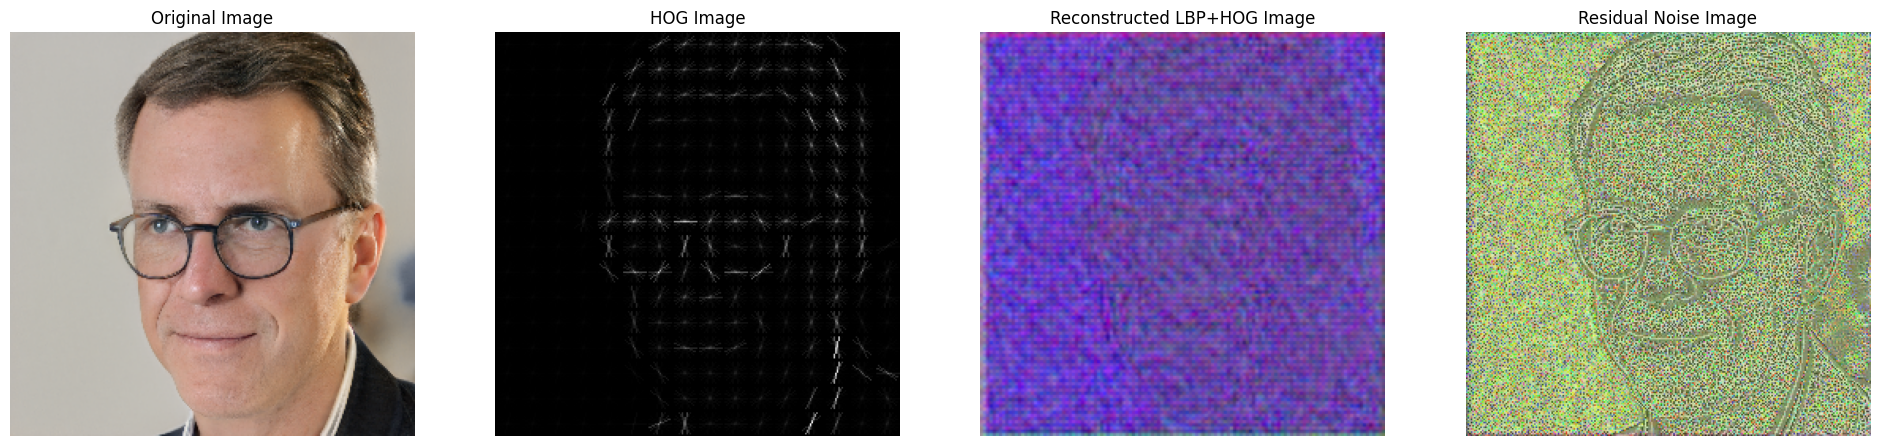

Classification result: tensor([[-0.0539, -0.1647]], device='cuda:0')


In [6]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms

# Select a random image from the train dataset
random_idx = random.randint(0, len(train_dataset) - 1)
image, hog_image, _ = train_dataset[random_idx]  # Updated to get HOG

# Add batch dimension
preprocessed_image = image.unsqueeze(0)
preprocessed_hog = hog_image.unsqueeze(0)

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetXception(num_classes=2).to(device)
model.eval()

# Forward pass
with torch.no_grad():
    preprocessed_image = preprocessed_image.to(device)
    preprocessed_hog = preprocessed_hog.to(device)
    reconstructed_image, residual_noise, classification = model(preprocessed_image, preprocessed_hog)

# Denormalize the original image
def denormalize(tensor):
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return tensor.clamp(0, 1)

# Convert images to PIL format
reconstructed_image = reconstructed_image.squeeze(0).cpu()  # Remove batch dimension
residual_noise = residual_noise.squeeze(0).cpu()  # Remove batch dimension
original_image = denormalize(image)
original_image_pil = transforms.ToPILImage()(original_image)

# Convert LBP+HOG images to uint8 format for visualization
def to_uint8(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return (tensor * 255).type(torch.uint8)

reconstructed_image_pil = transforms.ToPILImage()(to_uint8(reconstructed_image[:3]))  # Use first 3 channels for display
residual_noise_image_pil = transforms.ToPILImage()(to_uint8(residual_noise[:3]))  # Use first 3 channels for display

# Plot the original, HOG, reconstructed, and residual noise images
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
axes[0].imshow(original_image_pil)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(hog_image.squeeze(0).cpu().numpy(), cmap='gray')
axes[1].set_title("HOG Image")
axes[1].axis("off")

axes[2].imshow(reconstructed_image_pil)
axes[2].set_title("Reconstructed LBP+HOG Image")
axes[2].axis("off")

axes[3].imshow(residual_noise_image_pil)
axes[3].set_title("Residual Noise Image")
axes[3].axis("off")

plt.show()

# Print the classification result
print("Classification result:", classification)

Starting epoch 1/5


/tmp/ipykernel_31/905801536.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_31/905801536.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Epoch: 1 [0/11200 (0%)]	Loss: 0.177856	Elapsed time: 2.70s
Train Epoch: 1 [160/11200 (1%)]	Loss: 0.158394	Elapsed time: 10.91s
Train Epoch: 1 [320/11200 (3%)]	Loss: 0.130415	Elapsed time: 17.88s
Train Epoch: 1 [480/11200 (4%)]	Loss: 0.090983	Elapsed time: 24.70s
Train Epoch: 1 [640/11200 (6%)]	Loss: 0.039036	Elapsed time: 31.89s
Train Epoch: 1 [800/11200 (7%)]	Loss: 0.038538	Elapsed time: 38.69s
Train Epoch: 1 [960/11200 (9%)]	Loss: 0.040530	Elapsed time: 46.26s
Train Epoch: 1 [1120/11200 (10%)]	Loss: 0.002781	Elapsed time: 53.29s
Train Epoch: 1 [1280/11200 (11%)]	Loss: 0.026384	Elapsed time: 60.27s
Train Epoch: 1 [1440/11200 (13%)]	Loss: 0.018758	Elapsed time: 67.25s
Train Epoch: 1 [1600/11200 (14%)]	Loss: 0.027481	Elapsed time: 74.73s
Train Epoch: 1 [1760/11200 (16%)]	Loss: 0.014428	Elapsed time: 81.71s
Train Epoch: 1 [1920/11200 (17%)]	Loss: 0.027162	Elapsed time: 88.81s
Train Epoch: 1 [2080/11200 (19%)]	Loss: 0.056333	Elapsed time: 95.62s
Train Epoch: 1 [2240/11200 (20%)]	Los

/tmp/ipykernel_31/905801536.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation: [0/1600 (0%)]	Loss: 0.003068	Elapsed time: 2.62s
Validation: [160/1600 (10%)]	Loss: 0.000565	Elapsed time: 10.17s
Validation: [320/1600 (20%)]	Loss: 0.186321	Elapsed time: 17.33s
Validation: [480/1600 (30%)]	Loss: 0.059083	Elapsed time: 23.83s
Validation: [640/1600 (40%)]	Loss: 0.006195	Elapsed time: 30.76s
Validation: [800/1600 (50%)]	Loss: 0.099254	Elapsed time: 37.50s
Validation: [960/1600 (60%)]	Loss: 0.107468	Elapsed time: 44.55s
Validation: [1120/1600 (70%)]	Loss: 0.076593	Elapsed time: 51.55s
Validation: [1280/1600 (80%)]	Loss: 0.259466	Elapsed time: 58.11s
Validation: [1440/1600 (90%)]	Loss: 0.087239	Elapsed time: 64.77s
Epoch 1: Train Loss: 0.1343, Train Accuracy: 95.58% | Val Loss: 0.0943, Val Accuracy: 96.31% | Time: 575.01s
Starting epoch 2/5
Train Epoch: 2 [0/11200 (0%)]	Loss: 0.008180	Elapsed time: 2.66s
Train Epoch: 2 [160/11200 (1%)]	Loss: 0.007036	Elapsed time: 10.92s
Train Epoch: 2 [320/11200 (3%)]	Loss: 0.018095	Elapsed time: 17.64s
Train Epoch: 2 [480/11

/tmp/ipykernel_31/905801536.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


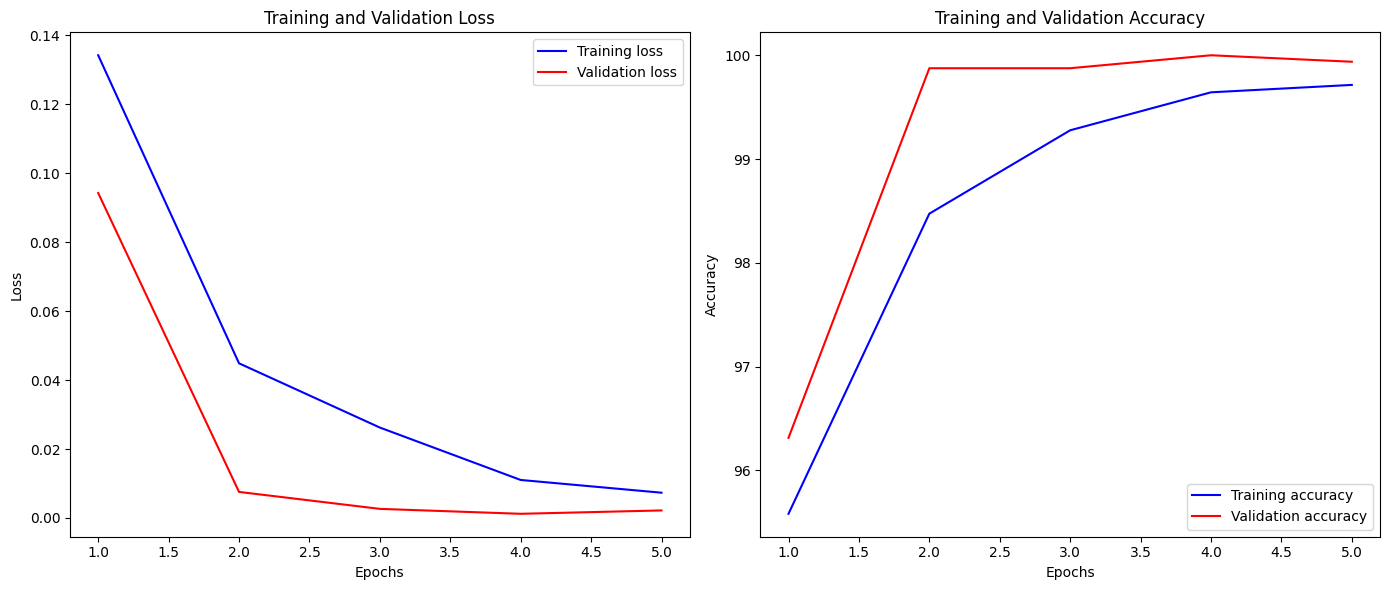

In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score
import time

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = UNetXception(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
scaler = GradScaler()

num_epochs = 5
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(model, device, train_loader, optimizer, epoch, accumulation_steps=4):
    model.train()
    train_loss = 0
    correct = 0
    start_time = time.time()

    for batch_idx, (data, hog, target) in enumerate(train_loader):
        data, hog, target = data.to(device), hog.to(device), target.to(device)
        optimizer.zero_grad()
        
        with autocast():
            out_resized, residual_noise, output = model(data, hog)
            loss = criterion(output, target)
            loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item() * accumulation_steps
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 10 == 0:
            elapsed = time.time() - start_time
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\tElapsed time: {elapsed:.2f}s')
        
    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    
    return train_loss, accuracy

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, hog, target) in enumerate(val_loader):
            data, hog, target = data.to(device), hog.to(device), target.to(device)
            with autocast():
                out_resized, residual_noise, output = model(data, hog)
                loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            if batch_idx % 10 == 0:
                elapsed = time.time() - start_time
                print(f'Validation: [{batch_idx * len(data)}/{len(val_loader.dataset)} '
                      f'({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}\tElapsed time: {elapsed:.2f}s')

    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    
    return val_loss, accuracy

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}/{num_epochs}")
    start_time = time.time()
    
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_accuracy = validate(model, device, val_loader)
    scheduler.step(val_loss)

    epoch_time = time.time() - start_time

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}% | Time: {epoch_time:.2f}s')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Plotting results
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_bpcer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    false_negatives = cm[0, 1]
    total_genuine = cm[0, 0] + cm[0, 1]
    bpcer = false_negatives / total_genuine
    return bpcer

def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer, eer_threshold

def calculate_deer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    deer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    deer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return deer, deer_threshold

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for data, hog, target in test_loader:
            data, hog, target = data.to(device), hog.to(device), target.to(device)
            with autocast():
                _, _, output = model(data, hog)
                loss = criterion(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_scores.extend(output[:, 1].cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f'Confusion Matrix:\n{cm}')
    
    return test_loss, accuracy, precision, recall, f1, all_labels, all_preds, all_scores

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds, all_scores = test(model, device, test_loader)

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, '
      f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1-Score: {test_f1:.4f}')

# Calculate BPCER
bpcer = calculate_bpcer(all_labels, all_preds)
print(f'BPCER: {bpcer:.4f}')

# Calculate EER
eer, eer_threshold = calculate_eer(all_labels, all_scores)
print(f'EER: {eer:.4f}, EER Threshold: {eer_threshold:.4f}')

# Calculate D-EER
deer, deer_threshold = calculate_deer(all_labels, all_scores)
print(f'D-EER: {deer:.4f}, D-EER Threshold: {deer_threshold:.4f}')

/tmp/ipykernel_31/2340373657.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Confusion Matrix:
[[1597    3]
 [   2 1598]]
Test Loss: 0.0060, Test Accuracy: 99.84%, Test Precision: 0.9984, Test Recall: 0.9984, Test F1-Score: 0.9984
BPCER: 0.0019
EER: 0.0019, EER Threshold: 0.0563
D-EER: 0.0019, D-EER Threshold: 0.0563
